In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
from lmfit import Parameters, Minimizer, conf_interval, printfuncs
import pandas as pd
from scipy.stats import median_abs_deviation

In [2]:
# load data
base = pd.read_csv('base_data.csv')
high_noise = pd.read_csv('hign_noise_data.csv')
more_components = pd.read_csv('more_components_data.csv')

# define fixed position
true_centers = {
        1: [1650],
        2: [1450, 1650],
        3: [1500, 1600, 1700],
        4: [1450, 1550, 1650, 1750],
        5: [1450, 1550, 1600, 1650, 1750], 
        6: [1400, 1500, 1550, 1650, 1700, 1800]
    }


In [36]:
def create_model(centers):
    model = None
    params = Parameters()
    
    for i, center in enumerate(centers):
        prefix = f'g{i}_'
        gauss = GaussianModel(prefix=prefix)
        
        if model is None:
            model = gauss
        else:
            model += gauss
        
        params.add(prefix+'center', value=center, vary=False)
        params.add(prefix+'amplitude', value=5, min=0.1, max=1000)
        params.add(prefix+'sigma', value=100, min=5, max=200)
        
    return model, params

# AICc & BIC
def calculate_metrics(result, n_params, data_length):
    if result is None or not result.success:
        return {'AICc': np.nan, 'BIC': np.nan}
    
    k = n_params 
    n = data_length
    rss = result.chisqr
    sigma_sq = rss / n 
    log_like = -0.5 * n * (np.log(2 * np.pi * sigma_sq) + 1)

    aic = 2*k - 2*log_like
    bic = k*np.log(n) - 2*log_like
    aicc = aic + (2*k*(k+1))/(n-k-1) if (n-k-1) > 0 else aic
    
    return {'AICc': aicc, 'BIC': bic, '-2lnL': -2*log_like}

# DIC
def compute_deviance(model, params, x, y, sigma):
    best_fit = model.eval(params, x=x)
    residuals = (y - best_fit) / sigma
    log_likelihood = -0.5 * np.sum(residuals**2)
    return -2 * log_likelihood 

def compute_DIC_bootstrap(model, result, x, y, sigma, n_samples=5000):
    D_values = []
    best_fit = model.eval(result.params, x=x)
    residuals = y - best_fit

    for _ in range(n_samples):
        resampled_residuals = np.random.choice(residuals, size=len(residuals), replace=True)
        y_resampled = best_fit + resampled_residuals
        res_residuals = (y_resampled - best_fit) / sigma
        logL = -0.5 * np.sum(res_residuals**2)
        D_values.append(-2 * logL)

    D_mean = np.mean(D_values)
    D_best = compute_deviance(model, result.params, x, y, sigma)
    p_D = D_mean - D_best
    DIC = D_mean + p_D
    return DIC, p_D

def compute_DIC_MCMC(model, result, x, y, sigma, n_samples=5000):
    D_best = compute_deviance(model, result.params, x, y, sigma)
    sampled_deviances = []
    # MCMC sampling: add Gaussian noise based on parameter uncertainties
    for _ in range(n_samples):
        sampled_params = result.params.copy()
        for name in result.var_names:
            if sampled_params[name].stderr is not None:
                sampled_params[name].value += np.random.normal(0, sampled_params[name].stderr)
        
        D_sample = compute_deviance(model, sampled_params, x, y, sigma)
        sampled_deviances.append(D_sample)
    
    D_mean = np.mean(sampled_deviances)
    p_D = D_mean - D_best
    DIC = D_mean + p_D
    
    return DIC, p_D

def compute_DIC_covariance(model, result, x, y, sigma, n_samples=8000):
    try:
        cov = result.covar
        param_names = [p for p in result.params if result.params[p].vary]
        mean = np.array([result.params[p].value for p in param_names])

        samples = np.random.multivariate_normal(mean, cov, size=n_samples)

        sampled_deviances = []
        for sample in samples:
            temp_params = result.params.copy()
            for i, p in enumerate(param_names):
                param = temp_params[p]
                val = sample[i]
                if param.min is not None:
                    val = max(val, param.min)
                if param.max is not None:
                    val = min(val, param.max)
                param.value = val

            try:
                y_pred = model.eval(temp_params, x=x)
                residuals = (y - y_pred) / np.clip(sigma, 0.1, None)
                residuals = np.clip(residuals, -1e4, 1e4)
                logL = -0.5 * np.sum(residuals**2)
                sampled_deviances.append(-2 * logL)
            except:
                continue

        # Remove outliers based on quantiles
        sampled_deviances = np.array(sampled_deviances)
        lower_q, upper_q = np.percentile(sampled_deviances, [1, 99])
        filtered_deviances = sampled_deviances[(sampled_deviances > lower_q) & (sampled_deviances < upper_q)]

        D_best = compute_deviance(model, result.params, x, y, sigma)
        D_mean = np.median(filtered_deviances)
        p_D = D_mean - D_best
        return D_mean + p_D, p_D

    except Exception as e:
        print(f"DIC Error: {str(e)}")
        return np.nan, np.nan
    



=== Base Dataset ===
 Components  -2ln(L)   AICc   ΔAICc    BIC    ΔBIC    p_D     DIC    ΔDIC
          1   5414.5 5418.5     0.0 5429.1     0.0    8.4  2461.3     0.0
          2   2765.0 2773.0 -2645.5 2794.2 -2634.9 8796.1 19390.9 16929.5
          3   1795.5 1807.5 -3610.9 1839.4 -3589.7   13.5  1569.4  -891.9
          4   -179.3 -163.2 -5581.6 -120.8 -5549.9    7.3  1514.6  -946.7
          5   -163.9 -143.8 -5562.3  -90.8 -5519.9  126.4  1753.1  -708.3
          6   -186.1 -161.9 -5580.3  -98.3 -5527.4   28.9  1557.9  -903.5

=== HighNoise Dataset ===
 Components  -2ln(L)   AICc  ΔAICc    BIC   ΔBIC   p_D    DIC   ΔDIC
          1   6524.0 6528.0    0.0 6538.6    0.0   4.7 1819.2    0.0
          2   5810.3 5818.3 -709.6 5839.6 -699.0  38.9 1602.7 -216.5
          3   5716.9 5728.9 -799.1 5760.8 -777.8   5.2 1510.3 -308.9
          4   5620.5 5636.6 -891.4 5679.0 -859.6   9.8 1519.9 -299.3
          5   5614.5 5634.6 -893.4 5687.6 -851.0  11.5 1523.3 -295.9
          6   5617.

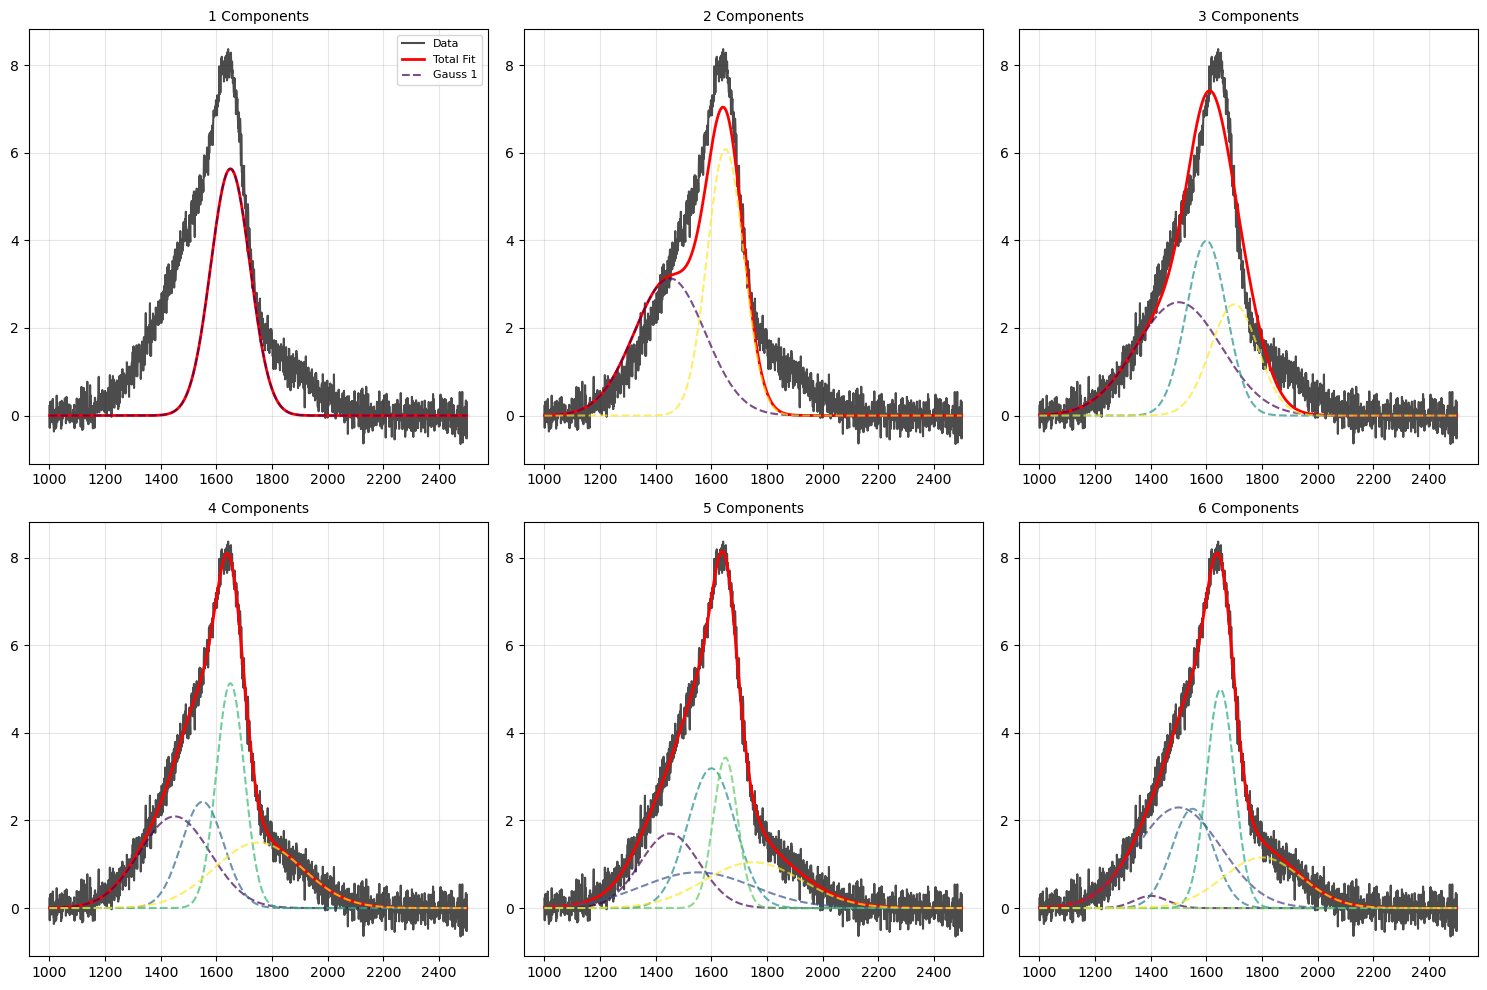

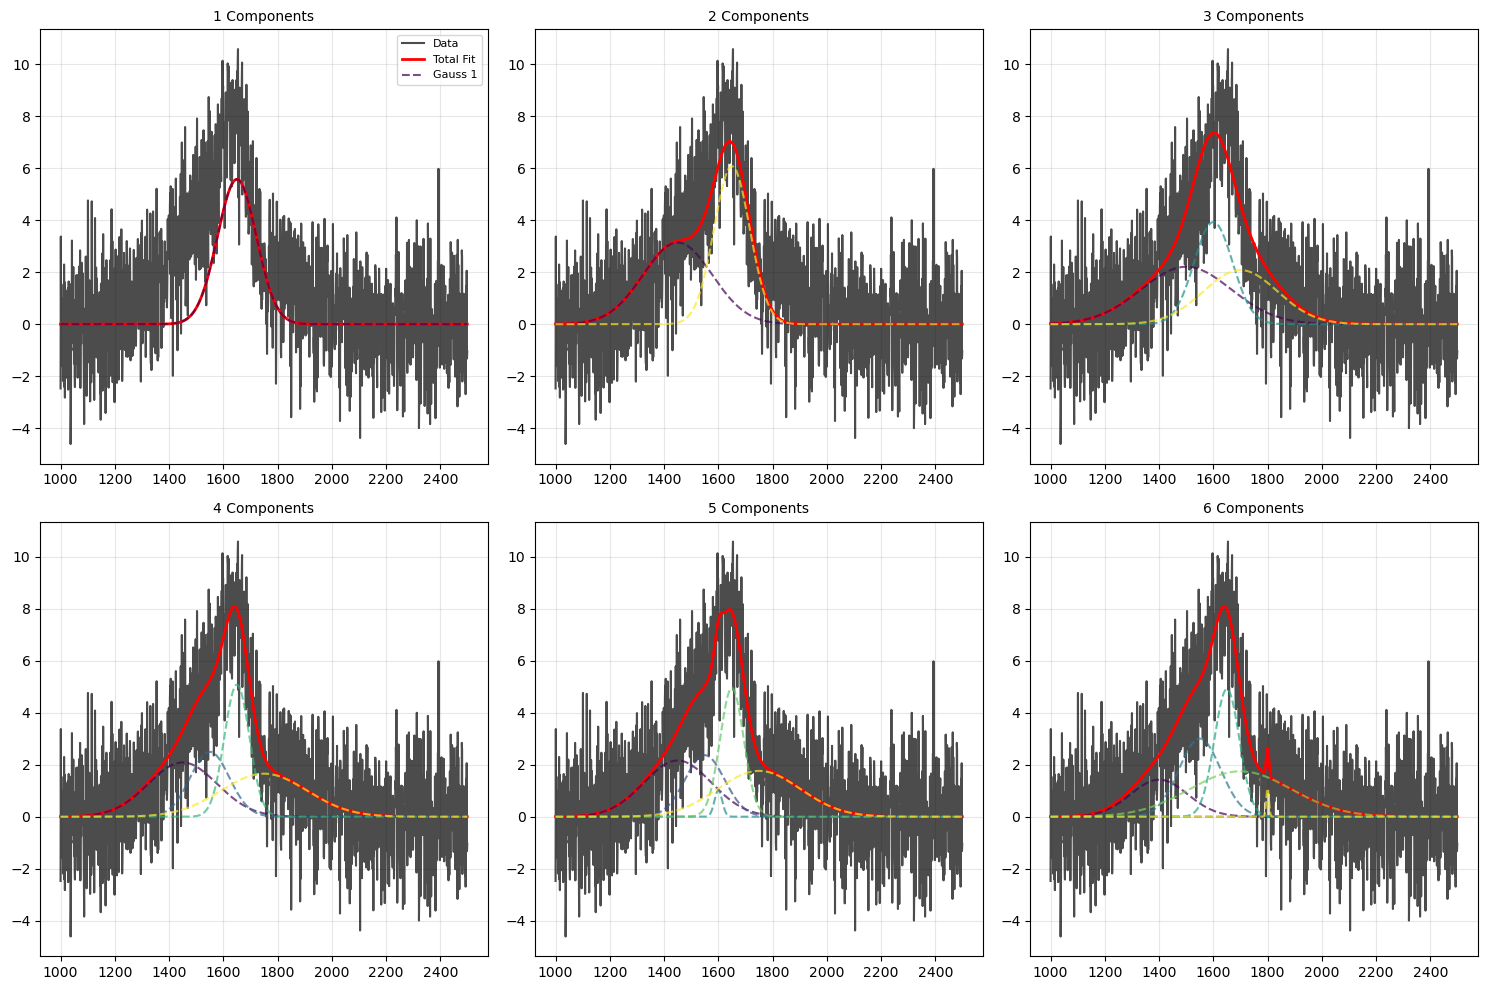

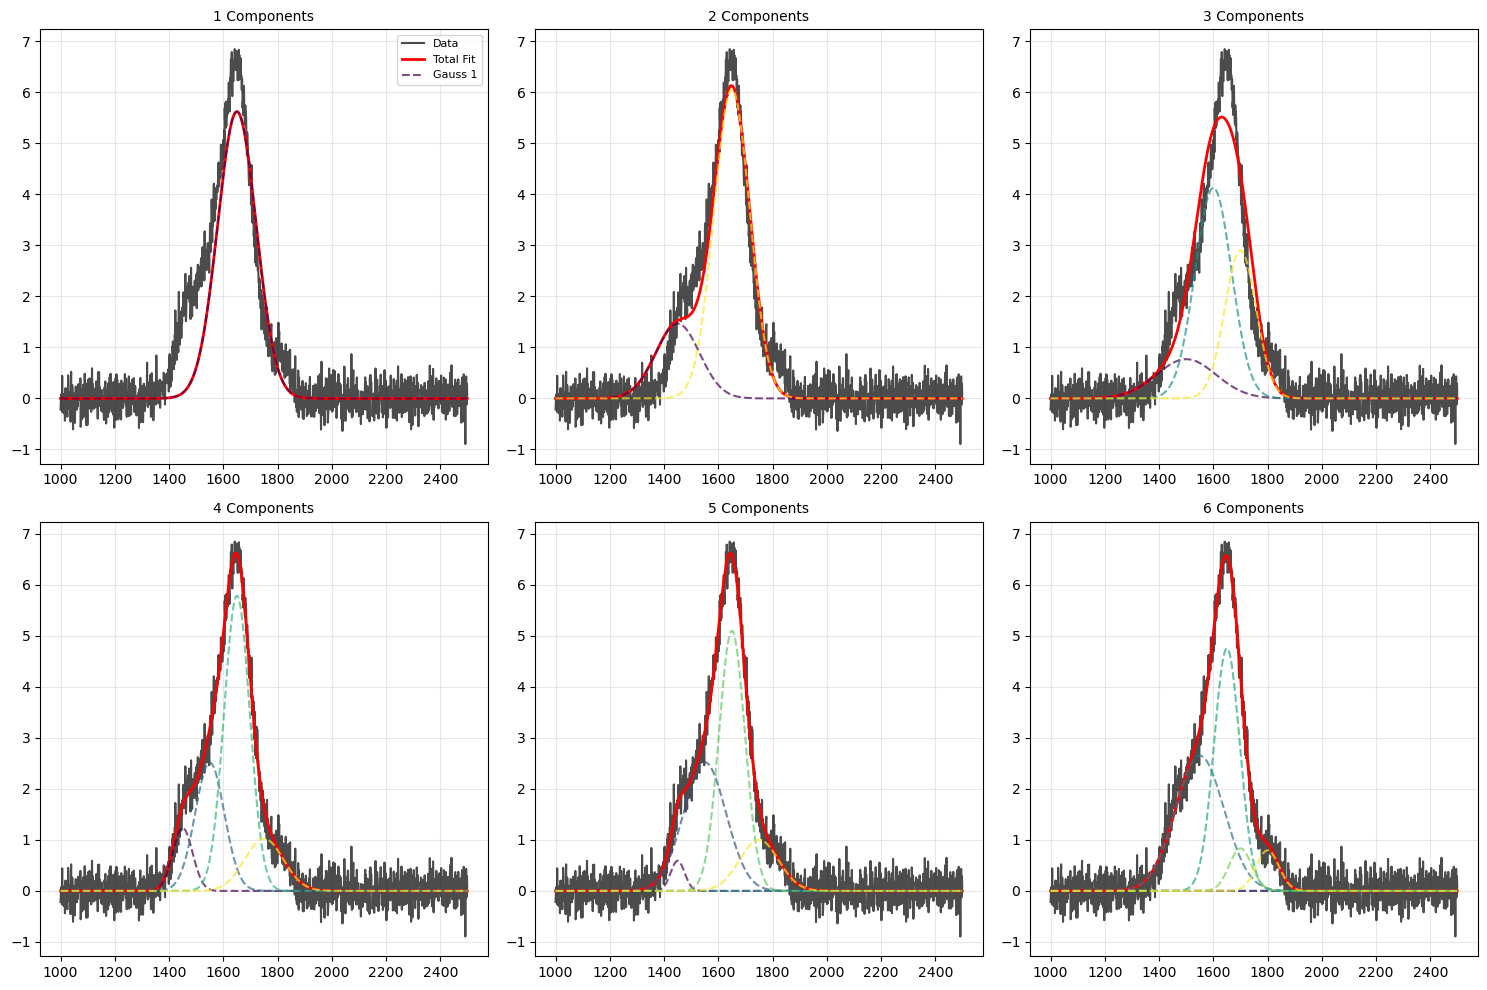

In [38]:
# model fitting
results = {}

for name, df in [('Base', base), 
                ('HighNoise', high_noise),
                ('Complex', more_components)]:
    x = df.Wavelength.values
    y = df.Flux.values
    
    criterion_df = pd.DataFrame()
    
    plt.figure(figsize=(15, 10))
    #plt.suptitle(f'{name} Dataset Fitting Results', fontsize=14, y=1.02)
    
    for n in range(1, 7):
        centers = true_centers[n]
        model, params = create_model(centers)
        result = model.fit(y, params, x=x)

        # AIC & BIC 
        metrics = calculate_metrics(result, 2*n, len(y))
        
        # DIC
        #given_sigma = 0.15 if name == 'Base' else 0.35
        #sigma = max(given_sigma, np.std(y - result.best_fit))
        sigma = np.std(y - result.best_fit) 
        DIC_value, p_D = compute_DIC_covariance(model, result, x, y, sigma)

        new_row = pd.DataFrame({
            'Components': [n],
            'AICc': [metrics['AICc']],
            'BIC': [metrics['BIC']],
            '-2ln(L)': [metrics['-2lnL']],
            'DIC': [DIC_value],
            'p_D': [p_D]
        })
        criterion_df = pd.concat([criterion_df, new_row], ignore_index=True)
        
        # plot result
        ax = plt.subplot(2, 3, n)
        ax.plot(x, y, 'k-', alpha=0.7, label='Data')
        
        ax.plot(x, result.best_fit, 'r-', lw=2, label='Total Fit')
        
        # components
        colors = plt.cm.viridis(np.linspace(0, 1, n))
        for i in range(n):
            comp = result.eval_components(x=x)[f'g{i}_']
            ax.plot(x, comp, '--', color=colors[i], 
                   alpha=0.7, label=f'Gauss {i+1}')
        
        ax.set_title(f'{n} Components', fontsize=10)
        ax.grid(alpha=0.3)
        if n == 1:
            ax.legend(loc='upper right', fontsize=8)
    
    base_row = criterion_df[criterion_df['Components'] == 1].iloc[0]
    base_aicc = base_row['AICc']
    base_bic = base_row['BIC']
    base_dic = base_row['DIC']
    criterion_df['ΔAICc'] = criterion_df['AICc'] - base_aicc
    criterion_df['ΔBIC'] = criterion_df['BIC'] - base_bic
    criterion_df['ΔDIC'] = criterion_df['DIC'] - base_dic
    criterion_df = criterion_df[['Components', '-2ln(L)', 'AICc', 'ΔAICc', 'BIC', 'ΔBIC','p_D', 'DIC', 'ΔDIC']]

    results[name] = criterion_df
    plt.tight_layout()
    plt.savefig(f'{name}_fitting.png')
    
    # print result
    print(f'\n=== {name} Dataset ===')
    print(criterion_df.to_string(index=False, float_format="%.1f"))

    